In [1]:
import cv2
import numpy as np
import os
import itertools
import torch.utils.data as utils_data

In [2]:
def processSkinImage(filePath, resize_HW=48):
    # step 1
    # read the image
    original = cv2.imread(filename=filePath)

    # step 2
    # resize the image to
    image_resized = cv2.resize(original, (resize_HW, resize_HW))

    # step 3
    # convert the image from rgb to YCbCr
    image_ycbcr = cv2.cvtColor(image_resized, cv2.COLOR_BGR2YCR_CB)

    # step 4
    # get the central color of the image
    # expected the hand to be in the central of the image
    Cb_center_color = image_ycbcr[int(resize_HW/2), int(resize_HW/2), 1]
    Cr_center_color = image_ycbcr[int(resize_HW/2), int(resize_HW/2), 2]
    # set the range
    Cb_Difference = 15
    Cr_Difference = 10

    # step 5
    # detect skin pixels
    Cb = image_ycbcr[:, :, 1]
    Cr = image_ycbcr[:, :, 2]
    index = np.where((Cb >= Cb_center_color-Cb_Difference) & (Cb <= Cb_center_color+Cb_Difference)
                     & (Cr >= Cr_center_color-Cr_Difference) & (Cr <= Cr_center_color+Cr_Difference))

    # Mark detected pixels and output
    image_output = np.zeros((resize_HW, resize_HW))
    image_output[index] = 255

    # show image
    # cv2.imshow("", image_output)
    # cv2.waitKey(0)
    return image_output

In [3]:
path = './task3'
path_processed = './task3_process/images'

# -------------------images processing--------------
for mainDir, subDir, fileList in os.walk(path):
    for file in fileList:
        currentPath = os.path.join(mainDir, file)
        # print("Processing file:", currentPath)
        processedImage = processSkinImage(currentPath)

        new_mainDir = path_processed + mainDir.split(path)[-1]
        if not os.path.exists(new_mainDir):
            os.makedirs(new_mainDir)
        cv2.imwrite(os.path.join(new_mainDir, file), processedImage)

# -----------------label generation----------------
label_path = './task3_process/labels'
if not os.path.exists(label_path):
    os.makedirs(label_path)

files = os.listdir(path)
for i, file in enumerate(files):
    subclass_label_path = os.path.join(label_path, file+'.txt')
    with open(subclass_label_path, 'w') as f:
        f.write('#label\n')
    for _ in range(len(os.listdir(os.path.join(path_processed, file)))):
        with open(subclass_label_path, 'a') as f:
            f.write('{:d}\n'.format(i))
    f.close()

In [4]:
Image = []
path_images = './task3_process/images'
for mainDir, subDir, fileList in os.walk(path_images):
    for file in fileList:
        currentPath = os.path.join(mainDir, file)
        Image.append(cv2.imread(currentPath)[:, :, 0])
Image = np.array(Image)
dataset_size, H, W = Image.shape
# # for FCNN model, the image need to be stretched into one dimension: (b, h, w)->(b, h*w)
# Image = Image.reshape(dataset_size, -1)


Label = []
path_labels = './task3_process/labels'
for file in os.listdir(path_labels):
    Label.append(np.loadtxt(os.path.join(path_labels, file)))
Label = np.array(list(itertools.chain.from_iterable(Label)))
num_classes = int(np.max(Label))+1

In [5]:
print('Image shape:', Image.shape)
print('Label shape:', Label.shape)

Image shape: (1185, 48, 48)
Label shape: (1185,)


In [6]:
import torch
import torch.nn.functional as F
import torch.utils.data as utils_data
class ConvModule(torch.nn.Module):
    def __init__(self,input_channel=1):
        super(ConvModule, self).__init__()
        
        self.conv = torch.nn.Sequential(
            # (batch_size, input_channel, H, W)->(batch_size, 32, H-2, W-2)
            torch.nn.Conv2d(in_channels=input_channel, out_channels=32, kernel_size=3, stride=1, padding=0),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(inplace=True),
            # (batch_size, 32, H-2, W-2)->(batch_size, 64, H-4, W-4)
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            # (batch_size, 64, H-4, W-4)->(batch_size, 128, H-6, W-6)
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(inplace=True)
        )
        #(128)->(4)
        self.fc = torch.nn.Linear(128, 5)

    def forward(self, X):
        # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        X=X.unsqueeze(1)
        # X = X.to(device)
        out = self.conv(X)  # (batch_size, 128, H - 6, W - 6)
        # 48-2-2-2=42
        out = F.avg_pool2d(out, 42)  # (batch_size, 128, 1, 1)
        # (batch_size, 128, 1, 1)->(batch_size, 128)
        out = out.squeeze()
        out = self.fc(out)
        return out

In [7]:
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvModule()
model.to(device)
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_func = nn.CrossEntropyLoss()

In [8]:
dataset = utils_data.TensorDataset(torch.Tensor(Image), torch.LongTensor(Label))
split_ratio = 0.8
train_size = int(split_ratio * dataset_size)
test_size = dataset_size - train_size
train_set, test_set = utils_data.random_split(dataset, [train_size, test_size])
train_loader = utils_data.DataLoader(dataset=train_set, batch_size=8, shuffle=True)
test_loader = utils_data.DataLoader(dataset=test_set, batch_size=8, shuffle=True)
print('Data is ready!')

Data is ready!


epoch=0	train loss=1.447074	train accuracy=0.435	test accuracy=0.553
epoch=1	train loss=1.181425	train accuracy=0.643	test accuracy=0.688
epoch=2	train loss=0.976711	train accuracy=0.801	test accuracy=0.886
epoch=3	train loss=0.817323	train accuracy=0.870	test accuracy=0.844
epoch=4	train loss=0.644973	train accuracy=0.918	test accuracy=0.333
epoch=5	train loss=0.512930	train accuracy=0.932	test accuracy=0.435
epoch=6	train loss=0.464993	train accuracy=0.928	test accuracy=0.249
epoch=7	train loss=0.377679	train accuracy=0.957	test accuracy=0.747
epoch=8	train loss=0.271741	train accuracy=0.972	test accuracy=0.684
epoch=9	train loss=0.249464	train accuracy=0.962	test accuracy=0.430
epoch=10	train loss=0.227945	train accuracy=0.967	test accuracy=0.532
epoch=11	train loss=0.222180	train accuracy=0.975	test accuracy=0.878
epoch=12	train loss=0.160467	train accuracy=0.972	test accuracy=0.983
epoch=13	train loss=0.126535	train accuracy=0.985	test accuracy=0.983
epoch=14	train loss=0.140518	t

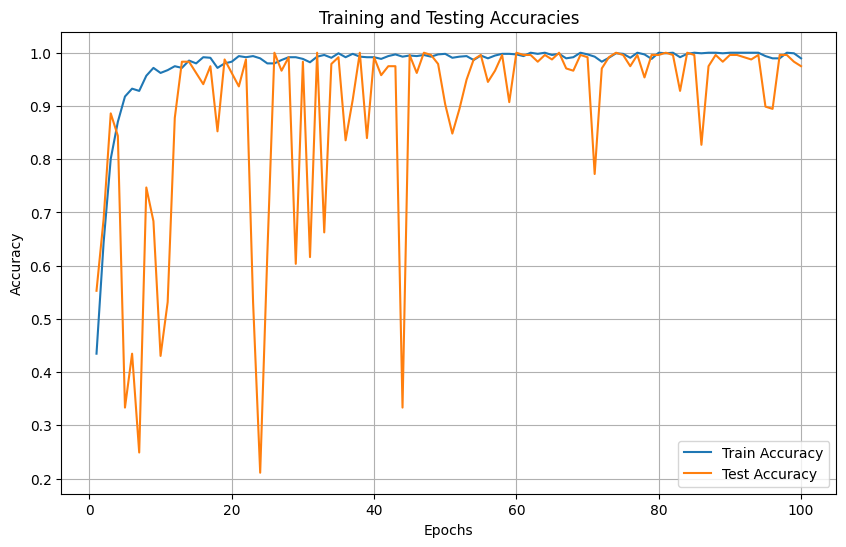

In [9]:
import matplotlib.pyplot as plt

# Lists to store training and testing accuracies for each epoch
train_accs = []
test_accs = []

best_accuracy = 0
for epoch in range(100):
    running_loss = 0.0
    train_acc = 0.0
    for step, (batch_image, batch_label) in enumerate(train_loader):
        model.train()
        model = model.to(device)
        batch_image, batch_label = batch_image.to(device), batch_label.to(device)
        batch_output = model(batch_image)
        batch_loss = loss_func(batch_output, batch_label)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        running_loss += batch_loss.item()

        _, train_predicted = torch.max(batch_output.data, 1)
        train_acc += (train_predicted == batch_label).sum().item()

    train_acc /= train_size
    running_loss /= (step + 1)

    model.eval()
    test_acc = 0.0
    for test_image, test_label in test_loader:
        test_image, test_label = test_image.to(device), test_label.to(device)
        test_output = model(test_image)
        _, predicted = torch.max(test_output.data, 1)
        test_acc += (predicted == test_label).sum().item()
    test_acc /= test_size

    print('epoch={:d}\ttrain loss={:.6f}\ttrain accuracy={:.3f}\ttest accuracy={:.3f}'.format(
        epoch, running_loss, train_acc, test_acc))

    # Append accuracies to the lists
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if test_acc >= best_accuracy:
        save_path = './task3_trained_models/'
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        torch.save(model.state_dict(), './task3_trained_models/FCNN_model.pkl')
        best_accuracy = test_acc

# Plot the training and testing accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(test_accs) + 1), test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracies')
plt.grid(True)
plt.show()
